# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

The aim of this material is to derive proximity operators for common regularizations:

- L1
- Group-L1 

and to use them in first order optimization algorithms for regression. The focus is on Ista / Fista for this notebook.

This work **must be done by pairs of students**. One document for each pair of students should be sent to: <alexandre.gramfort@telecom-paristech.fr>

**IMPORTANT**:
- use as object/title for your email **"TP1-DS-Optim"**
- the filename of the notebook **must be name1_name2.ipynb** (where name1 and name2 are the names of the students)

In [1]:
# to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

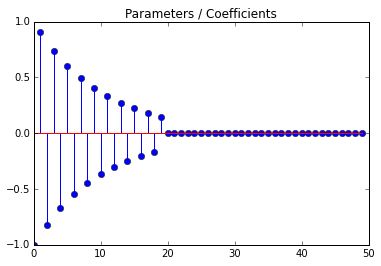

In [3]:
n_features = 50
n_samples = 2000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

In [4]:
# Simulation of the features matrix
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz

# Correlation
rho = 0.7

# Construction of a covariance matrix
cov = toeplitz(rho ** np.arange(0, n_features))

In [5]:
# Simulation of Gaussian vectors with this covariance matrix (it will be the features)
A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)


In [6]:
from numpy.random import randn

# Simulation of a linear model
std = 1.
noise = std * randn(n_samples)

# Simulation of the labels according to the linear regression model : b = A coefs + noise
b = A.dot(coefs) + noise

## Questions

- Visualize the covariance of the features. You can use plt.matshow.
- What is the influence of the rho parameter? Can you quantify it using the condition number of the generated matrix X? Use the `scipy.linalg.svd` function to extract the singular values of X.

<matplotlib.colorbar.Colorbar instance at 0x7fc720788d88>

/home/zapfack/tools/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


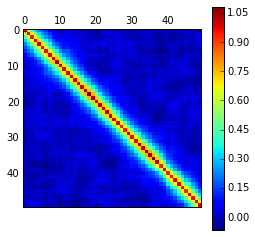

In [7]:
#features_cov = (A.T.dot(A))/(n_features**2)
features_cov = np.cov(A.T)
plt.matshow(features_cov)
plt.colorbar()

# Influence of Rho
La matrice de covariance de part sa construction est constituee de puissances consecutives de Rho (de 0 à -49). Pour cette raison les variables consécutives ont donc une covariance plus élevée que celles les éloignées.

In [8]:
# Conditionnement
# Valeurs propres de A
import scipy as sc
U, s, Vh = sc.linalg.svd(A.T.dot(A))
#U, s, Vh = sc.linalg.svd(A)
nu = np.min(s)
L = np.max(s)
conditionnement = L/nu
print conditionnement


35.6381618982


## Part 1 : Proximal operators

We remind that the proximal operator of the L1 norm used by the Lasso is defined by:

$$
\text{prox}(y) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + \lambda_1 \|x\|_1 \Big\}.
$$

It is given by the soft-thresholding operator:

$$
\text{prox}(y) = \text{sign}(y) \odot (|y| - \lambda_1)_+.
$$

In [9]:

def prox_lasso(x, l_l1):
    """Proximal operator for the L1 norm / Lasso at x"""
    x_abs = np.abs(x)
    return np.sign(x) * np.maximum(x_abs - l_l1, 0)

def lasso(x, l_l1):
    """Value of the Lasso penalization at x"""
    return l_l1 * np.abs(x).sum()

The proximal operator for the Elastic-Net is defined by:

$$
\text{prox}(y) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + \lambda_1 \|x\|_1 + \frac{\lambda_2}{2} \|x\|_2^2 \Big\}
$$

## Questions

- Implement the proximal operator of the Elastic-Net
- Visualize the functions applied element wise by the proximity operators of the Lasso (so called soft-thresholding function) and the Elastic-Net

In [10]:
from numpy.linalg import norm

def prox_enet(x, l_l1, l_l2):
    """Proximal operator for the elastic net at x"""
    x_abs = np.abs(x)
    return np.sign(x) * np.maximum(x_abs - l_l1, 0)/(1+l_l2)

def enet(x, l_l1, l_l2):
    """Value of the Elastic-net penalization at x"""
    
    return l_l1 * np.abs(x).sum() + l_l2/2*np.square(x).sum()

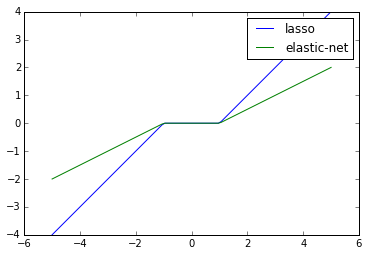

In [11]:
# Visualisation
x=np.linspace(-5,5,100)
plt.plot(x,prox_lasso(x, 1),label="lasso")
plt.plot(x,prox_enet(x, 1,1),label="elastic-net")
plt.legend()

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

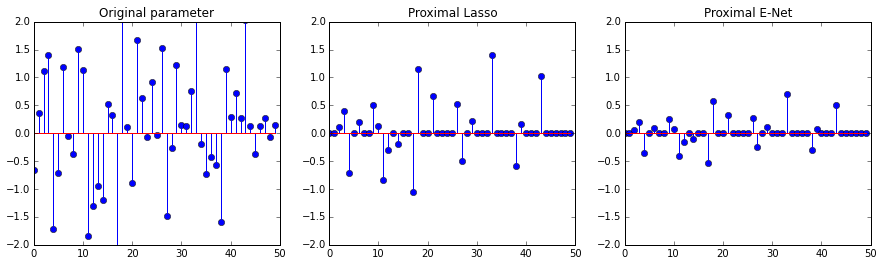

In [12]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter")
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, l_l1=l_l1))
plt.title("Proximal Lasso")
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_enet(x, l_l1=l_l1, l_l2=1.))
plt.title("Proximal E-Net")
plt.ylim([-2, 2])

## Question

- Comment what you observe (3 sentences max).

A cause des pénalités apportées par le lasso et elastic net, la taille de certains coefficients a été réduite et certains ont été annulés (l'utilisation de la norme 1 entraine des valeurs egales à 0 et la norme 2 entraine des valeurs peu grandes)

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below penalized linear regression problems, namely

$$
f(x) = \frac{1}{2 n} \| b - A x \|^2
$$

where $n$ is the sample size.

We therefore need to be able to compute $f$ and its gradient

### **Questions**:
- Code a function that computes the gradient of f
- Check that this function is correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``

In [13]:
# TO BE COMPLETED

# Least-squares loss
def f(x):
    return 0.5 * norm(b - A.dot(x)) ** 2 / n_samples

def grad_f(x):
    return (A.T.dot(A).dot(x)-A.T.dot(b))/n_samples
    

from scipy.optimize import check_grad

x = np.random.randn(n_features)

print check_grad(f, grad_f, x) # This should be a very small number

5.35159892742e-06


## Part 3: Solvers

We know have a function to compute $f$ and $g$ and their gradients. We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:
- Implement ISTA algorithm for the Elastic-Net.

- Implement FISTA algorithm for the Elastic-Net.

Remark: The `step` parameter will be taken as 1 / L

In [14]:
# TO BE COMPLETED

def ista(x0, l_l1=0., l_l2=0., step=None, n_iter=50, x_true=coefs):
    x = x0.copy()
    x_new = x0.copy()
    

    def prox_g(x, t):
        """Proximal operator for the elastic net at x"""
        x_abs = np.abs(x)
        #return np.sign(x) * np.maximum(x_abs - t*l_l1, 0)/(1+t*l_l2)
        #return prox_lasso(x, l_l1)
        return prox_enet(x,t*l_l1,t*l_l2)
            
    
    if step is None:
        step = n_samples/L  # TODO
    t=step

    # objective history
    objectives = []
    # Current objective
    obj = f(x) + g(x)
    objectives.append(obj)    
    print "Lauching ISTA solver..."    
    print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
    for k in range(n_iter):
        # ISTA update
        x[:] = prox_g(x-t*grad_f(x), t)
        #x_new
        #x[:] = x  # TODO
        obj = f(x) + g(x)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0:
            print ' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)])
    return x, objectives, errors

In [17]:
# TO BE COMPLETED

def fista(x0, l_l1=0., l_l2=0., step=None, n_iter=50, x_true=coefs):
    x = x0.copy()
    x_new = x0.copy()
    nu=1
    z_t = x0.copy()
    
    def g(x):
        return enet(x, l_l1, l_l2)

    def prox_g(x, t):
        """Proximal operator for the elastic net at x"""
        #x_abs = np.abs(x)
        #return np.sign(x) * np.maximum(x_abs - t*l_l1, 0)/(1+t*l_l2)
        return prox_enet(x,t*l_l1,t*l_l2)
            
    
    if step is None:
        step = n_samples/L  # TODO
    t=step   

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x)
    objectives.append(obj)    
    print "Lauching FISTA solver..."    
    print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
    for k in range(n_iter):
        # ISTA update
        x_new[:] = prox_g(z_t-t*grad_f(z_t), t)
        nu_2 = np.sqrt(nu**2 + (1/4.0))+(1/2.0)
        #nu_2 = (k+1)/2.0
        z_t = x_new + ((nu-1)/(nu_2))*(x_new-x)
        nu = nu_2
        x[:] = x_new
        #x[:] = x  # TODO
        obj = f(x) + g(x)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0:
            print ' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)])
    return x, objectives, errors

Let's launch the algorithms in order to compare them

In [18]:
x0 = np.zeros(n_features)
n_iter = 40
l_l1 = 5e-2
l_l2 = 1e-1
x_ista, obj_ista, err_ista = ista(x0, l_l1, l_l2, n_iter=n_iter)
x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter)

NameError: global name 'g' is not defined

### Algorithms comparison

NameError: name 'obj_ista' is not defined

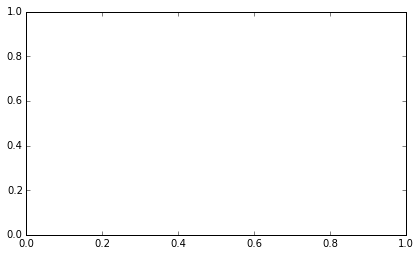

In [19]:
plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 2, 1)
plt.plot(obj_ista, label="ISTA", lw=2)
plt.plot(obj_fista, label="FISTA", lw=2)
plt.title("Objective")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(err_ista, label="ISTA", lw=2)
plt.plot(err_fista, label="FISTA", lw=2)
plt.legend()
plt.title("Estimation errors")

In [20]:
# Let's reduce the number of iterations and compare estimators
n_iter = 15
l_l1 = 3e-2
l_l2 = 1e-1

x_ista, obj_ista, err_ista = ista(x0, l_l1, l_l2, n_iter=n_iter)
x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter)

# Estimated parameters using ISTA, FISTA and Coordinate Descent
plt.rcParams['figure.figsize'] = (16.0, 4.0)
plt.subplot(1, 4, 1)
plt.stem(coefs)
plt.ylim([-1, 1])
plt.title("True parameter")
plt.subplot(1, 4, 2)
plt.stem(x_ista)
plt.ylim([-1, 1])
plt.title("ISTA Solution")
plt.subplot(1, 4, 3)
plt.stem(x_fista)
plt.ylim([-1, 1])
plt.title("FISTA Solution")

NameError: global name 'g' is not defined

### Questions

- Relaunch solvers with several values of rho (rho = 0.9, rho = 0.1). How does rho affect the convergence? Why?

2.13080413313
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.41e+00 | 5.20e-01
      10 | 1.13e+00 | 1.94e-01
      20 | 1.13e+00 | 1.94e-01
      30 | 1.13e+00 | 1.94e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.41e+00 | 5.20e-01
      10 | 1.13e+00 | 1.94e-01
      20 | 1.13e+00 | 1.94e-01
      30 | 1.13e+00 | 1.94e-01


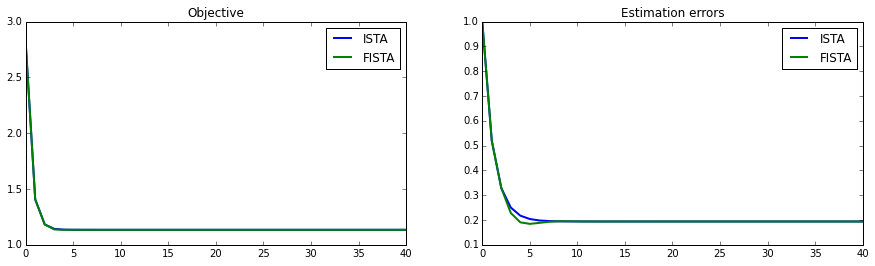

In [19]:
rho = 0.1
cov = toeplitz(rho ** np.arange(0, n_features))
A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
b = A.dot(coefs) + noise

U, s, Vh = sc.linalg.svd(A.T.dot(A))
nu = np.min(s)
L = np.max(s)
conditionnement = L/nu
print conditionnement

x0 = np.zeros(n_features)
n_iter = 40
l_l1 = 5e-2
l_l2 = 1e-1
x_ista, obj_ista, err_ista = ista(x0, l_l1, l_l2, n_iter=n_iter)
x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter)

plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 2, 1)
plt.plot(obj_ista, label="ISTA", lw=2)
plt.plot(obj_fista, label="FISTA", lw=2)
plt.title("Objective")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(err_ista, label="ISTA", lw=2)
plt.plot(err_fista, label="FISTA", lw=2)
plt.legend()
plt.title("Estimation errors")

315.518648774
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 7.55e-01 | 9.94e-01
      10 | 6.99e-01 | 9.59e-01
      20 | 6.88e-01 | 9.41e-01
      30 | 6.83e-01 | 9.29e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 7.55e-01 | 9.94e-01
      10 | 6.86e-01 | 9.36e-01
      20 | 6.78e-01 | 9.16e-01
      30 | 6.78e-01 | 9.25e-01


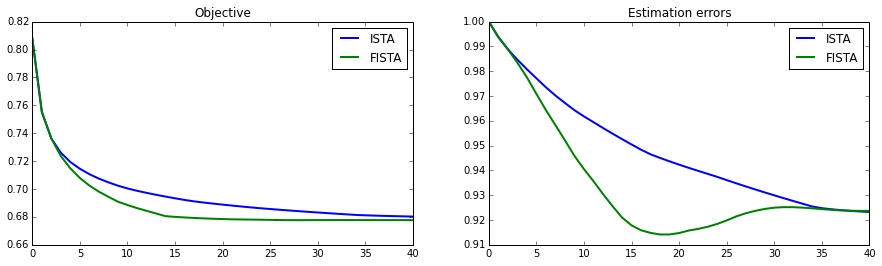

In [20]:
rho = 0.9
cov = toeplitz(rho ** np.arange(0, n_features))
A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
b = A.dot(coefs) + noise

U, s, Vh = sc.linalg.svd(A.T.dot(A))
nu = np.min(s)
L = np.max(s)
conditionnement = L/nu
print conditionnement

x0 = np.zeros(n_features)
n_iter = 40
l_l1 = 5e-2
l_l2 = 1e-1
x_ista, obj_ista, err_ista = ista(x0, l_l1, l_l2, n_iter=n_iter)
x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter)

plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 2, 1)
plt.plot(obj_ista, label="ISTA", lw=2)
plt.plot(obj_fista, label="FISTA", lw=2)
plt.title("Objective")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(err_ista, label="ISTA", lw=2)
plt.plot(err_fista, label="FISTA", lw=2)
plt.legend()
plt.title("Estimation errors")

# Influence de RHO sur la convergence

On remarque ainsi que le "condition number" augmente lorsque Rho augmente, celà signifie que la matrice des features est moins bien conditionnée, ce qui est normal car l'on a alors moins d'information dans nos données (les variables sont plus correlées). Il est donc logique qu'une décomposition en valeur singulières donne une valeur maximale plus grande et une valeur mimale plus faible.

Nous avons d'autre part vu (slide 80 du cours) que le vitesse de convergence est proportionnelle au pas (step) or nous l'avons choisi proportionnel à 1/L donc plus L est grand plus lente sera la convergence.

## Part 4. Multitask learning

We consider the setting of multitask learning, where instead of a single label $b_i$ we have ``n_tasks`` labels. The model writes

$$
B = A C + E
$$

where:
- $B$ is a (``n_samples``, ``n_tasks``) labels matrix
- $A$ is a (``n_samples``, ``n_features``) features matrix
- $C$ is a (``n_features``, ``n_tasks``) matrix of parameters to be estimated
- $E$ is a (``n_samples``, ``n_tasks``) noise matrix

Let's simulate this model:

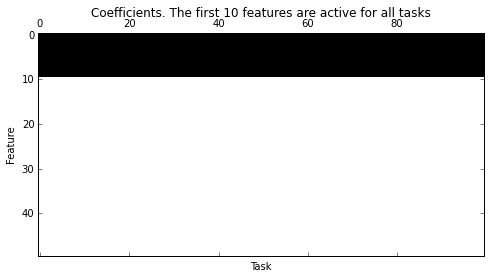

In [21]:
from numpy.random import randn
from matplotlib.cm import Greys

n_features = 50
n_samples = 2000
n_tasks = 100

std = 5.
noise = std * randn(n_samples, n_tasks)

coefs = np.zeros((n_features, n_tasks))
coefs[0:10, :] = 1.

B = A.dot(coefs) + noise

plt.matshow(coefs, cmap=Greys)
plt.title("Coefficients. The first 10 features are active for all tasks")
plt.xlabel("Task")
plt.ylabel("Feature")

**Questions:**

- Code the Lasso for the multitask problem using Fista (most of the previous code could be used as such)
- Plot the coefficients obtained 

In [22]:
def fista(x0, l_l1=0., l_l2=0., step=None, n_iter=50, x_true=coefs):
    x = x0.copy()
    x_new = x0.copy()
    nu=1
    z_t = x0.copy()
    
    def g(x):
        return lasso(x, l_l1)

    def prox_g(x, t):
        """Proximal operator for the lasso at x"""
        return prox_lasso(x,t*l_l1)
        #return prox_enet(x,t*l_l1,t*l_l2)
            
    
    if step is None:
        step = n_samples/L  # TODO
    t=step   

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x)
    objectives.append(obj)    
    print "Lauching FISTA solver..."    
    print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
    for k in range(n_iter):
        # ISTA update
        x_new[:] = prox_g(z_t-t*grad_f(z_t), t)
        nu_2 = np.sqrt(nu**2 + (1/4.0))+(1/2.0)
        #nu_2 = (k+1)/2.0
        z_t = x_new + ((nu-1)/(nu_2))*(x_new-x)
        nu = nu_2
        x[:] = x_new
        #x[:] = x  # TODO
        obj = f(x) + g(x)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0:
            print ' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)])
    return x, objectives, errors

In [23]:
# TO BE COMPLETED

# Multitask least-squares loss
def f(x):
    return 0.5 * norm(B - A.dot(x)) ** 2 / (n_samples * n_tasks)

def grad_f(x):
    return (A.T.dot(A).dot(x)-A.T.dot(B))/(n_samples)

x0 = np.random.randn(n_features, n_tasks)
print grad_f(x0).shape


n_iter = 50
l_l1 = 0.5
l_l2 = 0.
x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter, x_true=coefs)


(50, 100)
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.90e+03 | 2.15e+00
      10 | 7.32e+02 | 8.24e-01
      20 | 4.83e+02 | 4.33e-01
      30 | 4.76e+02 | 3.34e-01
      40 | 4.76e+02 | 3.10e-01


### Solution of the Lasso for the multitask problem

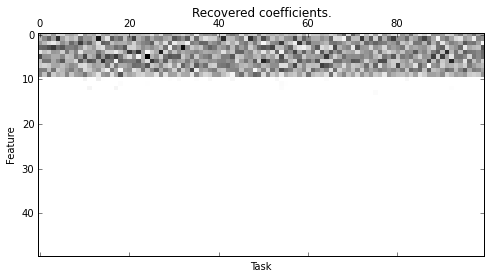

In [24]:
plt.matshow(x_fista, cmap=Greys)
plt.title("Recovered coefficients.")
plt.xlabel("Task")
plt.ylabel("Feature")

### Group-Lasso for the multitask problem

We want now to use group Lasso for the multitask problem. 
We consider then the Group-Lasso penalization, with proximal operator given by

$$
\text{prox}(Y) = \arg\min_X \Big\{ \frac 12 \|X - Y\|_F^2 + \lambda_{2, 1} \|X\|_{2, 1} \Big\},
$$

where

- $\|X\|_F$ is the Frobenius norm (matrix Euclidean norm)
- $\|X\|_{2, 1} = \sum_{j=1}^d \sqrt{\sum_{k=1}^K X_{j, k}^2}$ with $d$ being the number of features and $K$ the number of tasks

**Questions**

- Code the proximal operator of the Group-Lasso
- Based on the previous Fista solver, code a solver for the group-Lasso
- Launch the solver, comment and compare with the Lasso solution

In [27]:
X = np.random.randn(n_features, n_tasks)
l_group_l1=5.
test =np.asarray([X[i,:]-l_group_l1*X[i,:]/norm(X[i,:],2) if norm(X[i,:],2)>l_group_l1 else 0 for i in range(n_features)])
test.shape

(50, 100)

In [30]:
# TO BE COMPLETED

def group_lasso(X, l_group_l1):
    return l_group_l1 * np.sqrt((coefs ** 2).sum(axis=1)).sum()

def prox_group_lasso(X, l_group_l1):
    return np.asarray([X[i,:]-l_group_l1*X[i,:]/norm(X[i,:],2) if norm(X[i,:],2)>l_group_l1 else 0 for i in range(n_features)])
    #return [X[i,:]-l_group_l1*X[i,:]/norm(X[i,:],2) if norm(X[i,:],2)>l_group_l1 else 0 for i in range(n_features)]

def fista_group_lasso(x0, l_group_l1=1., step=None, n_iter=50, x_true=coefs):
    x = x0.copy()
    x_new = x0.copy()
    z = x0.copy()
    n_samples, n_features = A.shape

    def g(x):
        return group_lasso(x, l_l1)

    def prox_g(x, t):
        return prox_group_lasso(x,t*l_group_l1)
    
    if step is None:
        step = n_samples/ norm(A.T.dot(A), 2)

    errors = []
    objectives = []
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    obj = f(x) + g(x)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    print "Lauching FISTA solver..."    
    print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
    for k in range(n_iter):
        x_new[:] = prox_g(z - step * grad_f(z), step)
        t_new = (1. + (1. + 4. * t * t)) ** (0.5) / 2.
        z[:] = x_new + (t - 1) / t_new * (x_new - x)
        t = t_new
        x[:] = x_new
        obj = f(x) + g(x)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0:
            print ' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)])
    return x, objectives, errors

In [31]:
x0 = np.random.randn(n_features, n_tasks)
n_iter = 50
l_group_l1 = 5.
x_glasso, _, _ = fista_group_lasso(x0, l_group_l1, n_iter=n_iter, x_true=coefs)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 7.78e+01 | 2.12e+00
      10 | 6.29e+01 | 7.18e-01


ValueError: could not broadcast input array from shape (50) into shape (50,100)

In [ ]:
plt.matshow(x_glasso, cmap=Greys)
plt.title("Recovered coefficients.")
plt.xlabel("Task")
plt.ylabel("Feature")

** Extra questions**
- Code gradient and likelihood of the logistic regression model. Use ISTA and FISTA to solve penalized logistic regression
- Implement a backtracking linesearch in ISTA and FISTA (and increase the step at each iteration to accelerate)